In [31]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt #for visualizations
import seaborn as sns #for visualizations
import pickle

from datetime import datetime 
import nltk
from nltk.corpus import stopwords # to remove the stopwrods
from nltk.tokenize import word_tokenize #for tokenization
from nltk.stem import WordNetLemmatizer # for lemmitization

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split #to divide the corpus in train and test splits 
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score #For analysis
from tqdm.notebook import tqdm

from collections import Counter # to create a vocabulary with

# For CNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Conv1D, MaxPooling1D, Dropout, Activation
from tensorflow.keras.regularizers import l2

In [2]:
#https://www.kaggle.com/rodolfoluna/fake-news-detector
#https://12ft.io/proxy?q=http://towardsdatascience.com/text-classification-in-python-dd95d264c802

In [5]:
# Data is provided in two datasets, so we need to combine them

fake_news = pd.read_csv('./Data/Fake.csv')
fake_news['Fake'] = 1

# Load real news
real_news = pd.read_csv('./Data/True.csv')
real_news['Fake'] = 0

# Join the two dataframes
news = pd.concat([fake_news, real_news])

In [6]:
news.head()

,title,text,subject,date,Fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [7]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   Fake     44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [8]:
news.describe()

,Fake
count,44898.000000
mean,0.522985
std,0.499477
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [9]:
news.isna().sum()

title      0
text       0
subject    0
date       0
Fake       0
dtype: int64

# Visualise the data

Count of fake: 
1    23481
0    21417
Name: Fake, dtype: int64


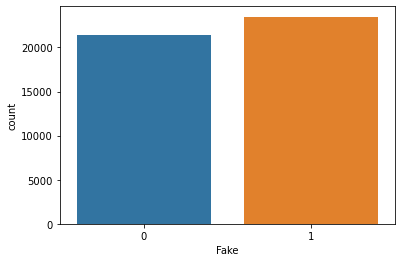

In [10]:
sns.countplot(x='Fake', data=news)
print("Count of fake: \n{}".format(news['Fake'].value_counts()))

In [11]:
average_lengths_true = []
average_lengths_false = []
count = 0
for true_article in real_news['text']:
    average_lengths_true.append(len(true_article))

for fake_article in fake_news['text']:
    average_lengths_false.append(len(fake_article))

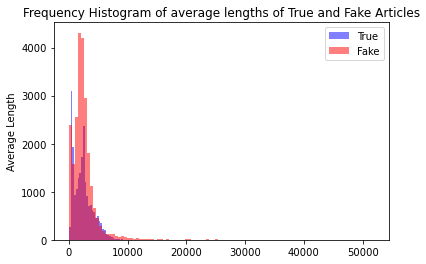

In [12]:
kwargs = dict(alpha=0.5, bins=100)
plt.hist(average_lengths_true, **kwargs, color='b', label='True')
plt.hist(average_lengths_false, **kwargs, color='r', label='Fake')
plt.gca().set(title='Frequency Histogram of average lengths of True and Fake Articles', ylabel='Average Length')
plt.legend();

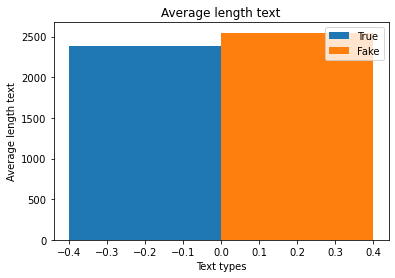

In [13]:
from statistics import mean

average_true_article_len = mean(average_lengths_true)
average_fake_article_len = mean(average_lengths_false)


X_axis = np.arange(1)
plt.bar(X_axis - 0.2, average_true_article_len, 0.4, label = 'True')
plt.bar(X_axis + 0.2, average_fake_article_len, 0.4, label = 'Fake')
  

plt.xlabel("Text types")
plt.ylabel("Average length text")
plt.title("Average length text")
plt.legend()
plt.show()


# Feature Engineering

In [14]:
news['date'] = pd.to_datetime(news['date'], errors='coerce')
news['Year'] = news['date'].dt.year
news['Month'] = news['date'].dt.month

news.head()

,title,text,subject,date,Fake,Year,Month
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,1,2017.0,12.0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,1,2017.0,12.0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,1,2017.0,12.0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,1,2017.0,12.0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,1,2017.0,12.0


<AxesSubplot:xlabel='Year', ylabel='count'>

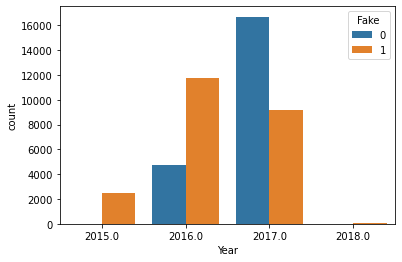

In [15]:
# Check the impact of Year on the target variable
sns.countplot(x='Year', data=news, hue='Fake')

<AxesSubplot:xlabel='Month', ylabel='count'>

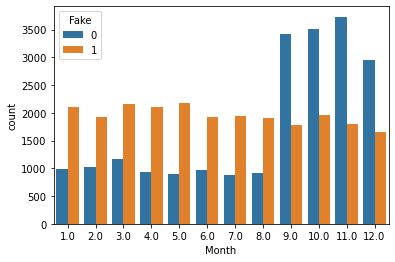

In [16]:
# Check the impact of Month on the target variable
sns.countplot(x='Month', data=news, hue='Fake')

In [17]:
#We want all information of an article, which would be the title, text and subject
news['Article'] = news['title']+""+news['text']+""+['subject']

In [18]:
final_news = news[['Article', 'Fake']]

# Prepare Data

## Lower and remove punctutation

In [19]:
final_news['Article'] = final_news['Article'].apply(lambda x: x.lower())

C:\Users\Simon\Anaconda3\envs\Captcha_env_v2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
final_news.head()

,Article,Fake
0,donald trump sends out embarrassing new year’...,1
1,drunk bragging trump staffer started russian ...,1
2,sheriff david clarke becomes an internet joke...,1
3,trump is so obsessed he even has obama’s name...,1
4,pope francis just called out donald trump dur...,1


In [21]:
# remove punctutations
def remove_punct(input_string):
    split_article = [char for char in input_string if char not in string.punctuation]
    clean_article = ''.join(split_article)
    return clean_article

In [22]:
final_news['Article'] = final_news['Article'].apply(remove_punct)

C:\Users\Simon\Anaconda3\envs\Captcha_env_v2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
final_news['Article'].head() 

0     donald trump sends out embarrassing new year’...
1     drunk bragging trump staffer started russian ...
2     sheriff david clarke becomes an internet joke...
3     trump is so obsessed he even has obama’s name...
4     pope francis just called out donald trump dur...
Name: Article, dtype: object

# Tokenize

In [25]:
for article in (final_news['Article']):
    #word_tokenize is a function from the nltk.tokenize package
    tokenized_article = word_tokenize(article)

## Stopwords

In [26]:
stopWords = stopwords.words('english')
filtered_document = []
filtered_article = []
#final_news['Article'].apply(lambda x: [item for item in tqdm(x) if item not in stopWords])

for sentence in final_news['Article']:
    #Having taken a sentence, remove the stopwords of that sentence
    for word in sentence:
        if word not in stopWords:
            #save the tokenized, stopword-less article in a list
            filtered_article.append(word)
    sentence = filtered_article
    
    #Add the filtered sentence to the overal documents list
    #filtered_document.append(sentence)
    
    #reset the sentence list so that we do not accidently save multiple articles as one article
    #filtererd_article = []
    

## Lemmatization

In [28]:
# Lemmatization function

lemmatizer = WordNetLemmatizer()

def lemmatize_text(article):
    #lemmatize each word in the article
    return [lemmatizer.lemmatize(word) for word in article]  
    

In [32]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Simon\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


True

In [33]:
# call the lemmatization function on each sentence in the corpus
#Cleaned_articles = []

for article in final_news['Article']:
    #this might go wrong --> the input is a list of tokenized words, so this might return individual lemmatized words
    # Might also go wrong by not being able to lemmatize a text --> would need to go one layer deeper
    lemmatizing_sentences = lemmatize_text(article)
    ##Cleaned_articles.append(lemmatizing_sentences)

Exception ignored in: <function tqdm.__del__ at 0x0000015CC53A34C8>
Traceback (most recent call last):
  File "C:\Users\Simon\Anaconda3\envs\Captcha_env_v2\lib\site-packages\tqdm\std.py", line 1147, in __del__
    self.close()
  File "C:\Users\Simon\Anaconda3\envs\Captcha_env_v2\lib\site-packages\tqdm\notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


In [34]:
final_news.head()

,Article,Fake
0,donald trump sends out embarrassing new year’...,1
1,drunk bragging trump staffer started russian ...,1
2,sheriff david clarke becomes an internet joke...,1
3,trump is so obsessed he even has obama’s name...,1
4,pope francis just called out donald trump dur...,1


In [35]:
for article in final_news["Article"]:
    article = final_news["Article"].array

In [36]:
# Pad the articles to make them all the same length
longest_article_length = len(max(final_news["Article"], key=len))


for article in final_news["Article"]:
    article = article.ljust(longest_article_length) 

In [37]:
X = final_news["Article"]
Y = final_news["Fake"]

In [38]:
counts = Counter(words for sublist in X for words in sublist)

# Build the model

### Bag of words model

Bag of words uses the occurences of words in the corpus. This is a great baseline and a surprisingly effective model for its simplicity

In [39]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Occurence_vector = TfidfVectorizer()
fitted_X = Occurence_vector.fit_transform(X)
Occurence_vector.get_feature_names_out() 


array(['00', '000', '0000', ..., 'émigré', 'état', 'žižek'], dtype=object)

In [36]:
# open a file, where you ant to store the data
file = open('./Data/fitted_X', 'wb')

# dump information to that file
pickle.dump(fitted_X, file)

# close the file
file.close()

In [29]:
# open a file, where you ant to store the data
file = open('./Data/X', 'wb')

# dump information to that file
pickle.dump(X, file)

# close the file
file.close()

# open a file, where you ant to store the data
file = open('./Data/Y', 'wb')

# dump information to that file
pickle.dump(Y, file)

# close the file
file.close()

# open a file, where you ant to store the data
file = open('./Data/Counts', 'wb')

# dump information to that file
pickle.dump(counts, file)

# close the file
file.close()

In [2]:
fitted_X = pickle.load( open( "./Data/fitted_X", "rb" ) )
X = pickle.load( open( "./Data/X", "rb" ) )
Y = pickle.load( open( "./Data/Y", "rb" ) )

In [3]:
fitted_X.shape

(44898, 248247)

In [4]:
X.shape

(44898,)

In [5]:
Y.shape

(44898,)

In [6]:

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state= 1, shuffle=True)

# SVM

In [40]:
#SVM model

svm_model = svm.SVC()
svm_model.fit(x_train, y_train)

SVC()

In [41]:
svm_prediction = svm_model.predict(x_test)

In [42]:
np.mean(svm_prediction == y_test)

0.9928730512249443

# LR

In [43]:
#Logistic regression model


LR_model = LogisticRegression(random_state=1).fit(x_train, y_train)
LR_prediction = LR_model.predict(x_test)


In [45]:
np.mean(LR_prediction == y_test)

0.9874164810690423

# CNN

For the CNN, various architectures can be used. After looking around online, we build upon the architecture described in section 2 of [Best practices document classification deep learning](https://machinelearningmastery.com/best-practices-document-classification-deep-learning/)

In [7]:
embeddings_dictionary = {}

##embedding_test = {}
#count = 0

f = open("./Data/glove.6b.100d.txt", encoding="utf8")


for line in f:
    #if count <= 5:
    #    print(f"LINE: {line}")

    values = line.split()
    #if count <= 5:
    #    print(f"values: {values}")

    word = values[0]
    #if count <= 5:
    #    print(f"WORD: {word}")

    coefficients = np.asarray(values[1:], dtype='float32')
    #if count <= 5:
    #    print(f"coefficients: {coefficients}")
    #    embedding_test[word] = coefficients

    embeddings_dictionary[word] = coefficients

    #count += 1
f.close()

LINE: the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062

values: ['the', '-0.038194', '-0.24487', '0.72812', '-0.39961', '0.083172', '0.043953', '-0.39141', '0.3344', '-0.57545', '0.08745

In [38]:
#embedding_test

{'the': array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
        -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
         0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
        -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
         0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
        -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
         0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
         0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
        -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
        -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
        -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
        -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
        -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
        -1.2526  ,  0.071624,  

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

vocab_size = len(tokenizer.word_index)
print(vocab_size)

276689


In [9]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 'on': 8,
 'for': 9,
 's': 10,
 'is': 11,
 'he': 12,
 'said': 13,
 'trump': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'his': 19,
 'by': 20,
 'has': 21,
 'be': 22,
 'have': 23,
 'not': 24,
 'from': 25,
 'at': 26,
 'this': 27,
 'are': 28,
 'who': 29,
 'us': 30,
 'an': 31,
 'they': 32,
 'but': 33,
 'would': 34,
 'we': 35,
 'i': 36,
 'about': 37,
 'president': 38,
 'will': 39,
 'their': 40,
 'had': 41,
 'you': 42,
 't': 43,
 'been': 44,
 'people': 45,
 'were': 46,
 'or': 47,
 'more': 48,
 'after': 49,
 'which': 50,
 'she': 51,
 'her': 52,
 'one': 53,
 'out': 54,
 'all': 55,
 'if': 56,
 'what': 57,
 'state': 58,
 'new': 59,
 'when': 60,
 'its': 61,
 'also': 62,
 'up': 63,
 'over': 64,
 'no': 65,
 'there': 66,
 'house': 67,
 'subject': 68,
 'our': 69,
 'clinton': 70,
 'donald': 71,
 'reuters': 72,
 'obama': 73,
 'government': 74,
 'can': 75,
 'states': 76,
 'just': 77,
 'than': 78,
 'him': 79,
 'republican': 8

In [10]:
embedding_matrix = np.zeros((vocab_size, 100))

In [11]:
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    
    #if index < 5:
    #    print(embedding_vector)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.27062 ]

In [12]:
x_train.shape

(35918,)

In [13]:
print(embedding_matrix.shape)

(276689, 100)


In [18]:
vocab_size

276689

In [21]:
longest_article_length = len(max(X, key=len))
print(longest_article_length)

50894


# Some sources regarding CNN

1. [Text Classification using CNN](https://www.kaggle.com/au1206/text-classification-using-cnn)
2. [Word Embeddings for movie review sentiment](https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/)
3. [Text Classification using CNN](https://12ft.io/proxy?q=http://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9)

In [ ]:
# CNN model

"""
Following the article mentioned above, we will implement a model using the following parameters  
        Transfer function: rectified linear.
        Kernel sizes: 3, 4, 5.
        Number of filters: 100
        Dropout rate: 0.5
        Weight regularization (L2): 3
        Batch Size: 50
        Update Rule: Adadelta
"""


#vocab_size = fitted_X.shape[0]
#print(vocab_size)
#print([embeddings_dictionary])


CNN_base_model = Sequential()
CNN_base_model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=longest_article_length, trainable=False))
CNN_base_model.add(Conv1D((vocab_size), 3, activation='relu', kernel_regularizer=l2(3)))
CNN_base_model.add(MaxPooling1D(2))
CNN_base_model.add(Dropout(0.5))
CNN_base_model.add(Conv1D(5000, 4, activation='relu', kernel_regularizer=l2(3)))
CNN_base_model.add(MaxPooling1D(2))
CNN_base_model.add(Dropout(0.5))
CNN_base_model.add(Conv1D(1000, 5, activation='relu', kernel_regularizer=l2(3)))
CNN_base_model.add(MaxPooling1D(2))
CNN_base_model.add(Dropout(0.5))
CNN_base_model.add(Conv1D(100, 5, activation='relu', kernel_regularizer=l2(3)))
CNN_base_model.add(MaxPooling1D(2))
CNN_base_model.add(Dropout(0.5))
CNN_base_model.add(Flatten())
CNN_base_model.add(Dense(1, activation='sigmoid'))

# compile the CNN_base_model
CNN_base_model.compile(optimizer='Adadelta', loss='binary_crossentropy', metrics=['acc'])



# summarize the CNN_base_model
print(CNN_base_model.summary())

In [ ]:
import tensorflow as tf

train_data_tf = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_data_tf = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [ ]:
model = CNN_base_model.fit(x_train, y_train, batch_size=50,epochs=10,verbose=1,validation_data=(x_test, y_test))

In [ ]:
CNN_base_model.fit(train_data_tf, epochs=10, validation_data=valid_data_tf, batch_size=50)

# CNN Attempt 2

In [3]:
docs = X
docs

0         donald trump sends out embarrassing new year’...
1         drunk bragging trump staffer started russian ...
2         sheriff david clarke becomes an internet joke...
3         trump is so obsessed he even has obama’s name...
4         pope francis just called out donald trump dur...
                               ...                        
21412    fully committed nato backs new us approach on ...
21413    lexisnexis withdrew two products from chinese ...
21414    minsk cultural hub becomes haven from authorit...
21415    vatican upbeat on possibility of pope francis ...
21416    indonesia to buy 114 billion worth of russian ...
Name: Article, Length: 44898, dtype: object

In [9]:
docs.describe()

count                                                 44898
unique                                                39105
top       highlights the trump presidency on april 13 at...
freq                                                      8
Name: Article, dtype: object

In [11]:
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size_2 = len(t.word_index) + 1

In [35]:
vocab_size_2

276690

In [ ]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs)

In [22]:
# pad documents to a max length of 4 words
max_length = len(max(X, key=len))
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[146457     20   1927  26803    660]
 [146460     20    368   6876    660]
 [146493     20   4324   9325    660]
 ...
 [    55    154     12     13     68]
 [   476    668     16   9807     68]
 [     5   5843    318    461     68]]


In [16]:
embeddings_dictionary_v2 = {}

f = open("./Data/glove.6b.100d.txt", encoding="utf8")


for line in f:
    values = line.split()
    word = values[0]
    coefficients = np.asarray(values[1:], dtype='float32')
    embeddings_dictionary_v2[word] = coefficients
f.close()

print('Loaded %s word vectors.' % len(embeddings_dictionary_v2))


Loaded 400000 word vectors.


In [23]:
embedding_matrix_v2 = np.zeros((vocab_size_2, 100))

for word, index in t.word_index.items():
    #if index > nb_words - 1:
    #    break
    #else:
    embedding_vector_v2 = embeddings_dictionary_v2.get(word)
    if embedding_vector_v2 is not None:
        embedding_matrix_v2[index] = embedding_vector_v2

In [24]:
len(embedding_matrix_v2)

276690

In [37]:
# define model
model = Sequential()
e = Embedding(vocab_size_2, 100, weights=[embedding_matrix_v2], input_length=4, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 4, 100)            27669000  
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 401       
Total params: 27,669,401
Trainable params: 401
Non-trainable params: 27,669,000
_________________________________________________________________


In [ ]:
CNN_base_model_test = Sequential()
CNN_base_model_test.add(Embedding(vocab_size_2, 100, weights=[embedding_matrix_v2], input_length=1000, trainable=False))
CNN_base_model_test.add(Conv1D((vocab_size_2), 4, activation='relu', kernel_regularizer=l2(3)))
CNN_base_model_test.add(Conv1D((vocab_size_2//2), 4, activation='relu', kernel_regularizer=l2(3)))
CNN_base_model_test.add(MaxPooling1D(2))
CNN_base_model_test.add(Dropout(0.5))
CNN_base_model_test.add(Conv1D(1000, 5, activation='relu', kernel_regularizer=l2(3)))
CNN_base_model_test.add(MaxPooling1D(2))
CNN_base_model_test.add(Dropout(0.5))
CNN_base_model_test.add(Conv1D(100, 5, activation='relu', kernel_regularizer=l2(3)))
CNN_base_model_test.add(MaxPooling1D(2))
CNN_base_model_test.add(Dropout(0.5))
CNN_base_model_test.add(Flatten())
CNN_base_model_test.add(Dense(1, activation='sigmoid'))

# compile the CNN_base_model_test
CNN_base_model_test.compile(optimizer='Adadelta', loss='binary_crossentropy', metrics=['acc'])


In [ ]:
# fit the model
CNN_base_model_test.fit(padded_docs, Y, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = CNN_base_model_test.evaluate(padded_docs, Y, verbose=0)
print('Accuracy: %f' % (accuracy*100))

# Further questioning? 

1. Do we need to keep the length of the articles at the maximum? Might be a better idea to create cut-off points
2. Is the text cleaning and tokenization correct?
3. Is the GloVe embedding and correaltion to own text imported and worked correcty?
4. How to decide the best architecture? Currently just copying other ideas
    4a. For example, When to decide multiple layers after each other? When to add pooling?
        I understand from the lectures the theoretics behind it, but I am having trouble converting it to actual code  

In [27]:
len(max(X, key=len))

50894

In [29]:
lengths = X.str.len() 

In [30]:
argmax = np.where(lengths == lengths.max())[0]

In [33]:
X.iloc[argmax]

22303    media tripwire ping pong pizza conspiracy prop...
23086    media tripwire ping pong pizza conspiracy prop...
Name: Article, dtype: object

In [34]:
print(X[22303])

media tripwire ping pong pizza conspiracy propels internet censorship amid ‘fake news’ witchhunt funny how secrets travel i d start to believe if i were to bleed    lyrics written by david bowie from the album outsideshawn helton 21st century wire in the days before the us presidential election in november 2016 wikileaks revealed a new string of emails connected to hillary clinton s 2016 campaign chairman john podesta online interpretations of the leaked podesta email exchanges subsequently led to a digital firestorm on social media producing an intense conspiratorial  open source investigation  still in search of its smoking gun however the phenomenon now known by its hashtag pizzagate has since set a number of tertiary events into motion is there a real story hidden amongst the debris of this online explosionis it possible that  open source investigators  were being led into a virtual culdesac and thus missing the real storymore importantly could people be playing into the hands of t

In [ ]:
#XGBoost (XGBClassifier)? RNN?

# Evaluation